# Project: Hard disks molecular dynamics simulations

Clyde Fare and João Pedro Malhado, Imperial College London (contact: [python@imperial.ac.uk](mailto:python@imperial.ac.uk))

Notebook is licensed under a [Creative Commons Attribution 4.0 (CC-by) license](http://creativecommons.org/licenses/by/4.0/).

A computational chemist friend of mine once defined simulations in the following terms:

<blockquote>Experimental work resembles the actions of a child that receives a big wrapped present, and without opening it, by shaking it in his hands and hearing the sound it makes, has to infer what is inside the box and how it works. Simulation on the other hand, is like starting with an empty box, fill it with pieces that we know well, close and wrap the box, and shake it to hear the sound it makes. By comparing the two sounds, we may be able to understand nature a little better.
(Philipp Marquetand, sometime around 2009)</blockquote>

This project is about building a 2D box, filling it with disks, and hearing what sound it makes.

## The model

We are aiming to create a program to describe the motion of an ensemble of classical particles in a 2 dimensional space. Unlike the ideal gas model, we will consider that the particles possess volume (area in 2D) and therefore collide with each other. Apart from these collisions we consider no other interaction between particles. Such a system is identical to that programmed by Nick Brooks as [demonstrations for the Chemical Equilibria course](http://www.imperial.ac.uk/chemistry-teaching/chemicalequilibria/).

Such simulation is one of the simplest examples of a class of simulation methods called [molecular dynamics](https://en.wikipedia.org/wiki/Molecular_dynamics), describing the time evolution of an ensemble of particles according to classical dynamics. In spite of its simplicity, such hard disks model is able to give insight on important results from thermodynamics, reaction kinetics, the structure of dense fluids, or phase transition.

The description of the dynamical state of the system involves the determination of the position $\vec{r}_i(t)$ and momentum $\vec{p}_i(t)$ (or velocity) of each particle of the system at each moment of time. For systems of N particles (where N is usually fairly large) it is in general not possible to write a closed form mathematical expression for how these quantities vary in time. The solution to this problem is to use numerical methods by which, starting from a given initial state, the system is propagated forward in time by a small discrete amount $\Delta t$ (called a time step), and new the position and momentum are calculated for every particle for time $t+\Delta t$. By repeating this process over and over again, it is possible to obtain a "picture" of the system at small intervals of time and thus monitor its evolution.

Our simulation will thus be:

* Create an ensemble of particles with positions in a bound region of space with size L&times;L, each with a well defined momentum and mass.
* Sequentially updating the position and momenta of these particles in small time steps, keeping a registry of the configurations taken by the system over time.

## Outline of the program design

Our task is thus to write a program to implement the simulation of the system outlined above. The object-oriented approach is actually quite helpful in these early stages of the design in deciding how to structure our program. This exercise is usually better done with pen and paper with a few schematics than in front of a computer keyboard.

In the most simple terms, our simulation can be viewed as an ensemble of particles that need to be propagated in time. We can thus think of two distinct classes of objects:

* Particle class, denoting the state of an individual particle at a given moment in time. This should be a fairly simple class.
* Simulation class, responsible for the time propagation of an ensemble of Particle objects. This is where most of the work will be done.

The time evolution of the particles should be a relatively simple affair since particles don't interact (except for collisions), each particle should follow uniform linear motion (constant velocity) until an elastic collision occurs with another particle or the container walls, in which case we need to work out how to update the momenta.

Note that this 2 class design is not unique. There could for example be several advantages in creating a third class representing the state of the box as a collection of particles at each time step. A Simulation object would then propagate these box objects in time. We will however stick to two class design.

We shall slowly build all the functionality of the simulation.

* First we will crate a Particle class with the particle attributes.
* We will then see how to propagate this particle in time in the absence of collisions.
* The create a Simulation class to propagate an ensemble of non-colliding particles.
* The most tricky bit of the simulation will be to implement the behaviour when collisions occur. First, collisions with the container walls (easier), then between particles (less simple).
* After having a working simulation, we will look at some properties of the systems we are simulating.

## Some preliminaries

Rather than working directly in the notebook we will build our classes inside a file: gas_2d.py using an editor. We will then visualise and test the code inside the notebook.

Open gas_2d.py using the Python editor Spyder (you can find it in your list of programs). Inside gas_2d.py you will find three class definitions, Vector, Particle and Simulation. 

We will be making heavy use of the Vector class, which is already filled out and is much the same as the Vector class we developed in the last workshop with a few additional methods that allow us to add and subtract vectors and multiply and divide vetors by numbers using the usual +-/\* operators. Particle and Simulation are just the outlines of the class. You will need to replace *pass* with code as you as you progress through the project.

Each time we update our code we need to run the command

    %run gas_2d.py

before our changes can be used in the notebook.

We now import some auxiliar functions which will help to visualise the simulation that you will construct.

In [4]:
%matplotlib notebook
from aux_functions import animate_trajectory, display_particle, display_vecs, display_trajectory

## Building a Particle Class

The first class we need to fill out is the Particle class which will unsurprisingly represent... *drum roll* ...particles. Once we can create particle objects we can start building our Simulation class which will represent the total simulation and will include multiple Particle objects.

For our purposes the properties that define a single particle will be position and momentum (both of them are vectors), as well as mass and radius (both of them are scalars). In the skeleton of the class below replace *pass* with code so that the particle class has position/momentum/radius attributes.

We will want a method *velocity* which will return the velocity of the particle (recall that our expanded Vector class allows us to divide vectors by scalars). We will also want a method *copy* which will return an identical copy of the Particle shown below is a skeleton of the class we want to construct. Edit gas_2d.py by filling out the particle class.

    class Particle():
        def __init__(self, position, momentum, radius, mass):
            pass

        def velocity(self):
            pass
            
        def copy(self):
            pass

In the cell below use your particle class to create a particle object and then use the display_particle auxiliar function on it to display it. (Remember to %run gas_2d.py)

In order to initialise your particle you'll need to create two vectors one for position and one for momentum and provide your particle with a radius and a mass.

<IPython.core.display.Javascript object>


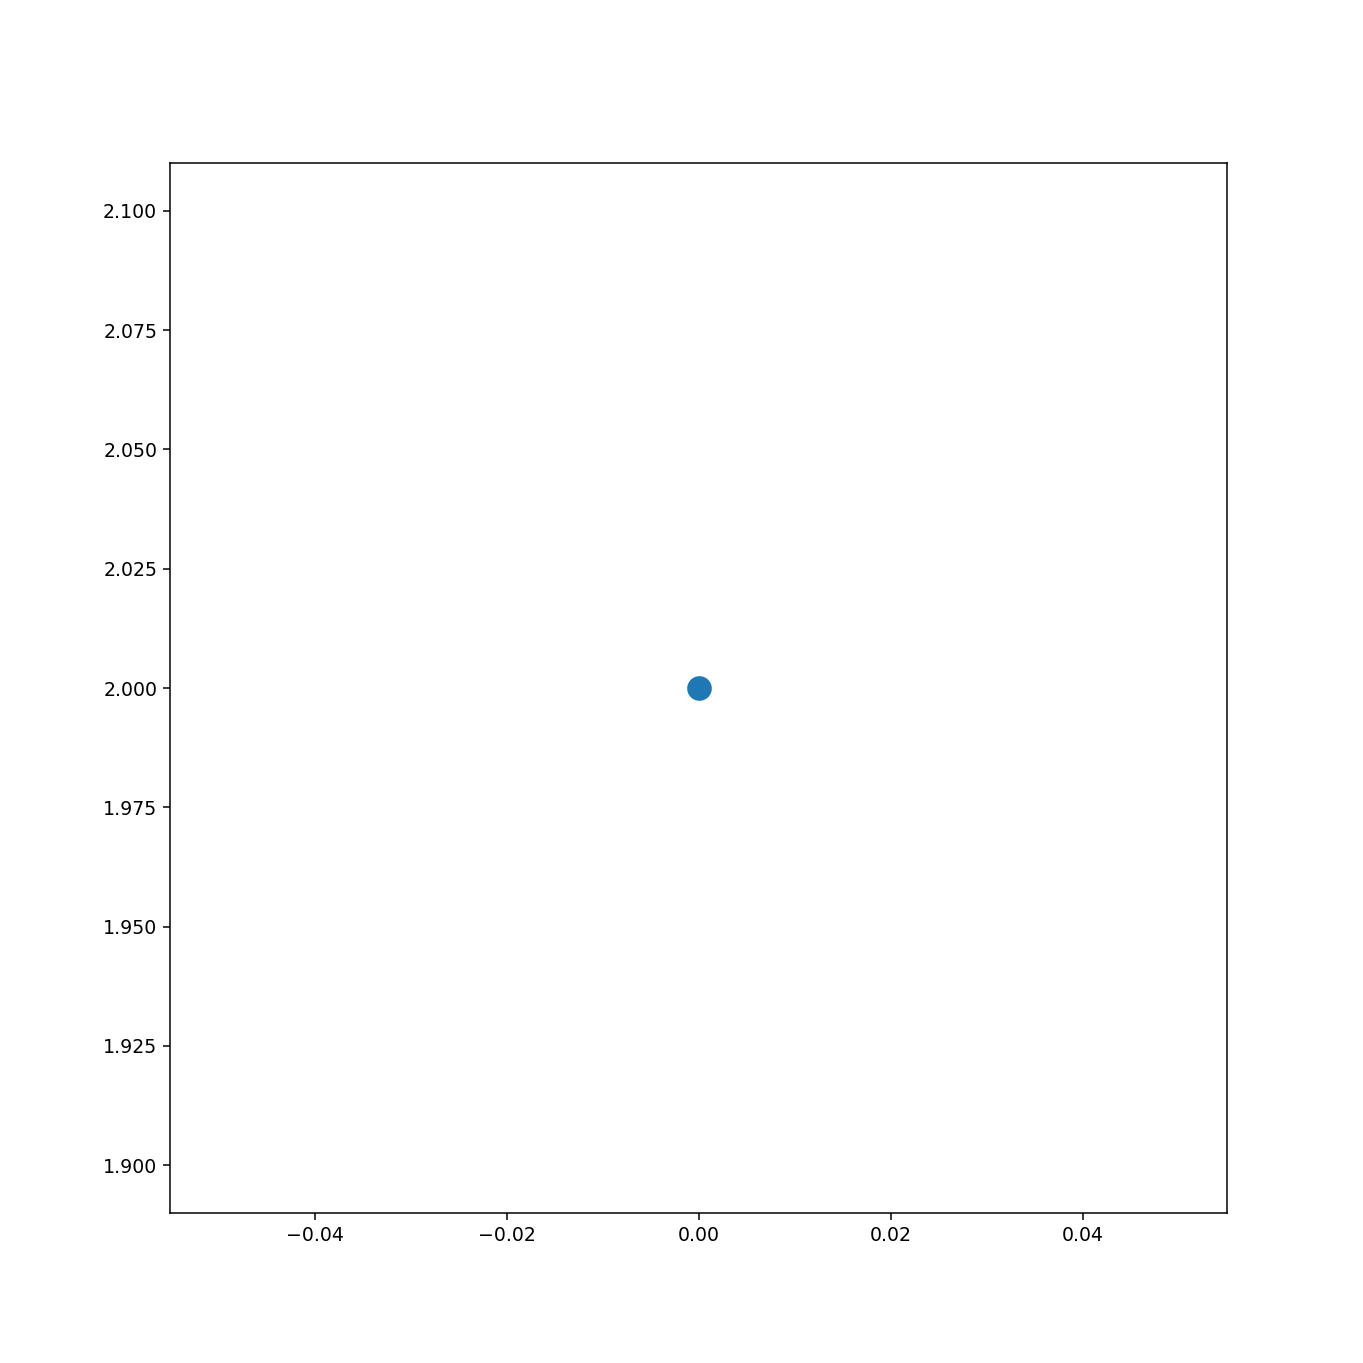

In [12]:
%run gas_2d.py
a = Particle( Vector(0, 2 ), Vector(2, 1 ), 1 ,1 )
display_particle(a)

A plot showing your particle should have popped up. Bask in the glory of the particle you have created.

## Making our particle move

Ok now we can create individual particles but they aren't doing too much. Let's try generate a trajectory. As our particle is a free particle experiencing no forces the momentum will not change with time. The position however will change. In a small amount of time $\Delta t$ the position will change via:

$$\vec{r}(t+\Delta t)=\vec{r}(t)+\vec{v}(t)\times \Delta t$$

where $\vec{r}(t)$ is the position at time $t$, $\vec{v}(t)$ is velocity and $\Delta t$ is the time step.

The trajectory of the particle, understood in this context as a sequence of particle positions recorded in consecutive time steps, is obtained by running our simulation for a certain number of time steps. During each step we will use the velocity to update the position and then record the particle using the list.

Fill out the cell so that during each iteration the particle's position is updated, you'll also want to append a copy of the particle object to the trajectory list so that we have a record of the particle at every time step.

<IPython.core.display.Javascript object>


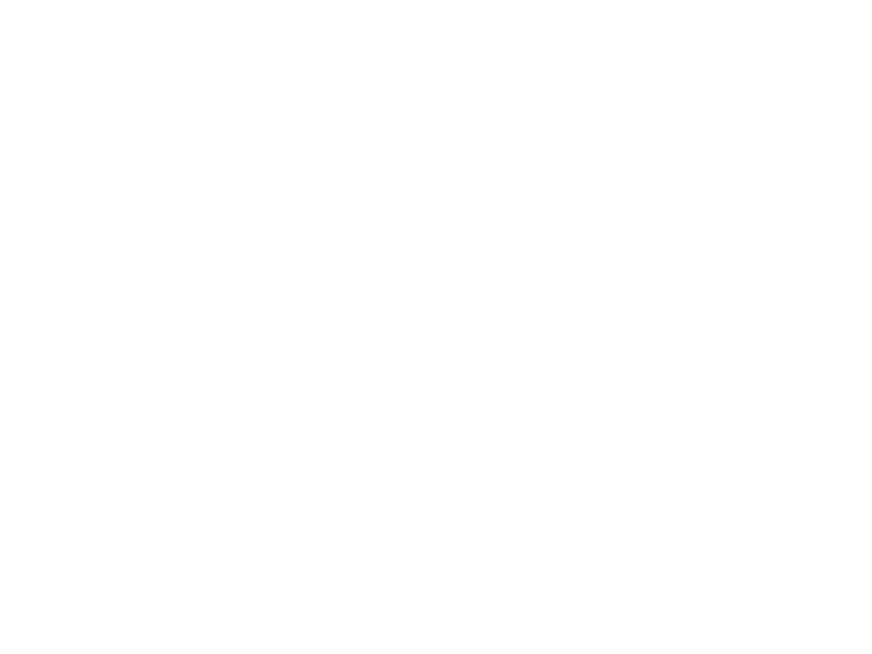

In [13]:
%run gas_2d.py

no_steps = 1000
dt = 0.01

trajectory = []
for step in range(1,no_steps+1):
    b=a.copy()
    trajectory = trajectory + [a.copy()]
    v = a.velocity()
    displacement = v*dt
    a.position = a.position + displacement

Use the display_trajectory function on the positions list to view the motion of your particle

<IPython.core.display.Javascript object>


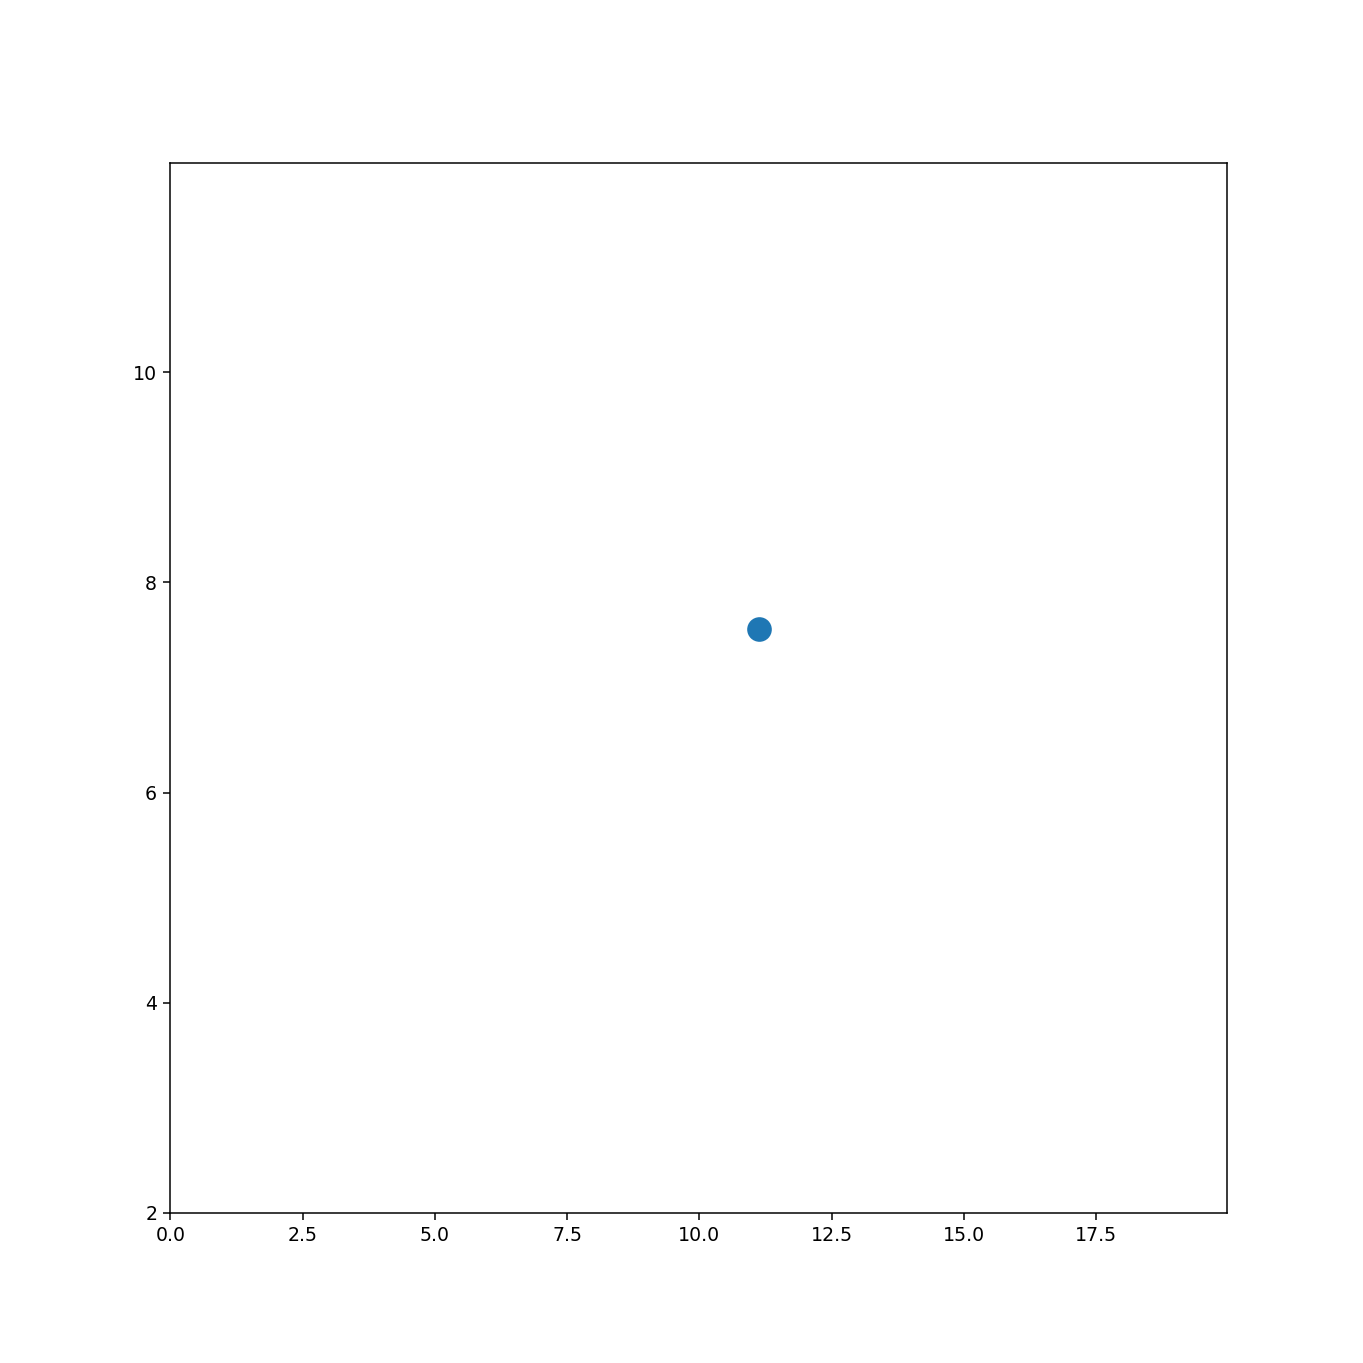

In [14]:
display_trajectory(trajectory)

## Building a Simulation class

Great! We're going to take a step sideways now and introduce our main simulation class. The code you wrote above calculated the position of a single particle for multiple time steps.

This time we're going to have many particles but we're only going to calculate their position for a single time step. Below is a skeleton for our simulation class, it will be initialised with a list of particles, a number box_length and another number dt. It includes a method *step* which is where the action takes place. The step method should loop over every particle and update the particle's position using it's momentum and the time step dt.

    class Simulation():
        def __init__(self, particles, box_length, dt):
            pass

        def step(self):
            pass

Test your simulation class using the code below (we're printing out the y coordinate of the first particle at the start of the simulation and after we have updated the positions). Do you understand what's being printed out?

In [5]:
%run gas_2d.py

particles = [Particle(Vector(0.5,0),Vector(0,1),1,1),
             Particle(Vector(0.5,1),Vector(0,-1),1,1),
             Particle(Vector(0,0), Vector(0.5,0.5),1,1)]

s=Simulation(particles, 100,1)

print(s.particles[0].position.y)
s.step()
print(s.particles[0].position.y)
s.step()
print(s.particles[0].position.y)

0
1.0
0.5


## Recording the state of the simulation

We also want to record the state of the particles so we can have a look at the trajectories our particles have taken during the simulation and process our data.

The code below shows another simulation class skeleton, which has added a record_state method. This method should loop over each particle and append a copy of the particle to the state list. Once done it should append the state list to the trajectory attribute.

You will want to call the record\_state method in the initialization method such that the initial state of the system is the first element of the trajectory list. More importantly, you should call record\_state at the end of step method so that every time we update the particles we record them. Update your Simulation class to include the record\_state method and call it from your \_\_init\_\_ and step methods.

    class Simulation():
        def __init__(self, particles, box_length, dt):
            self.trajectory = []

        def step(self):
            pass

        def record_state(self):
            state = []

Test your code using the cell below:

<IPython.core.display.Javascript object>


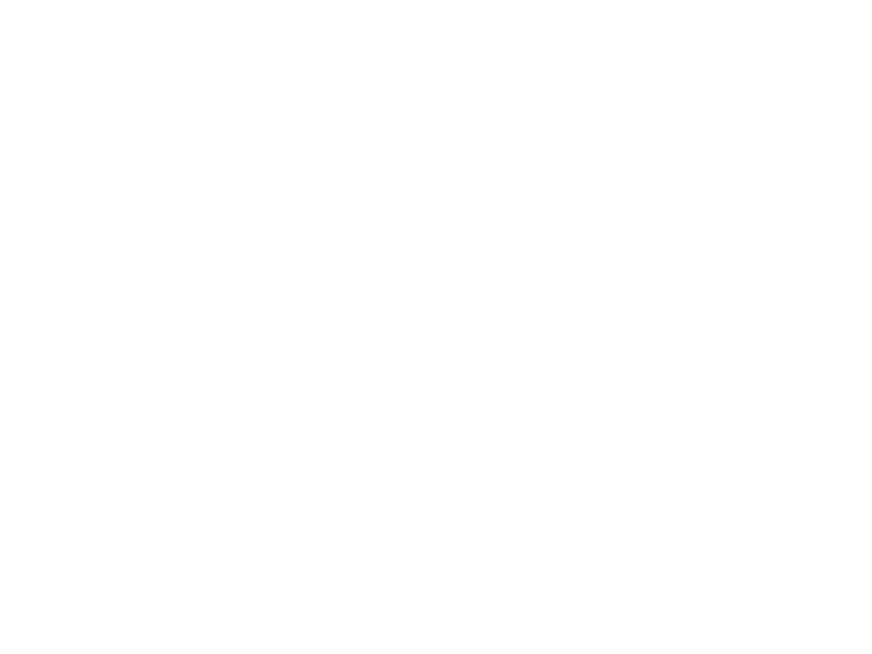

<IPython.core.display.Javascript object>


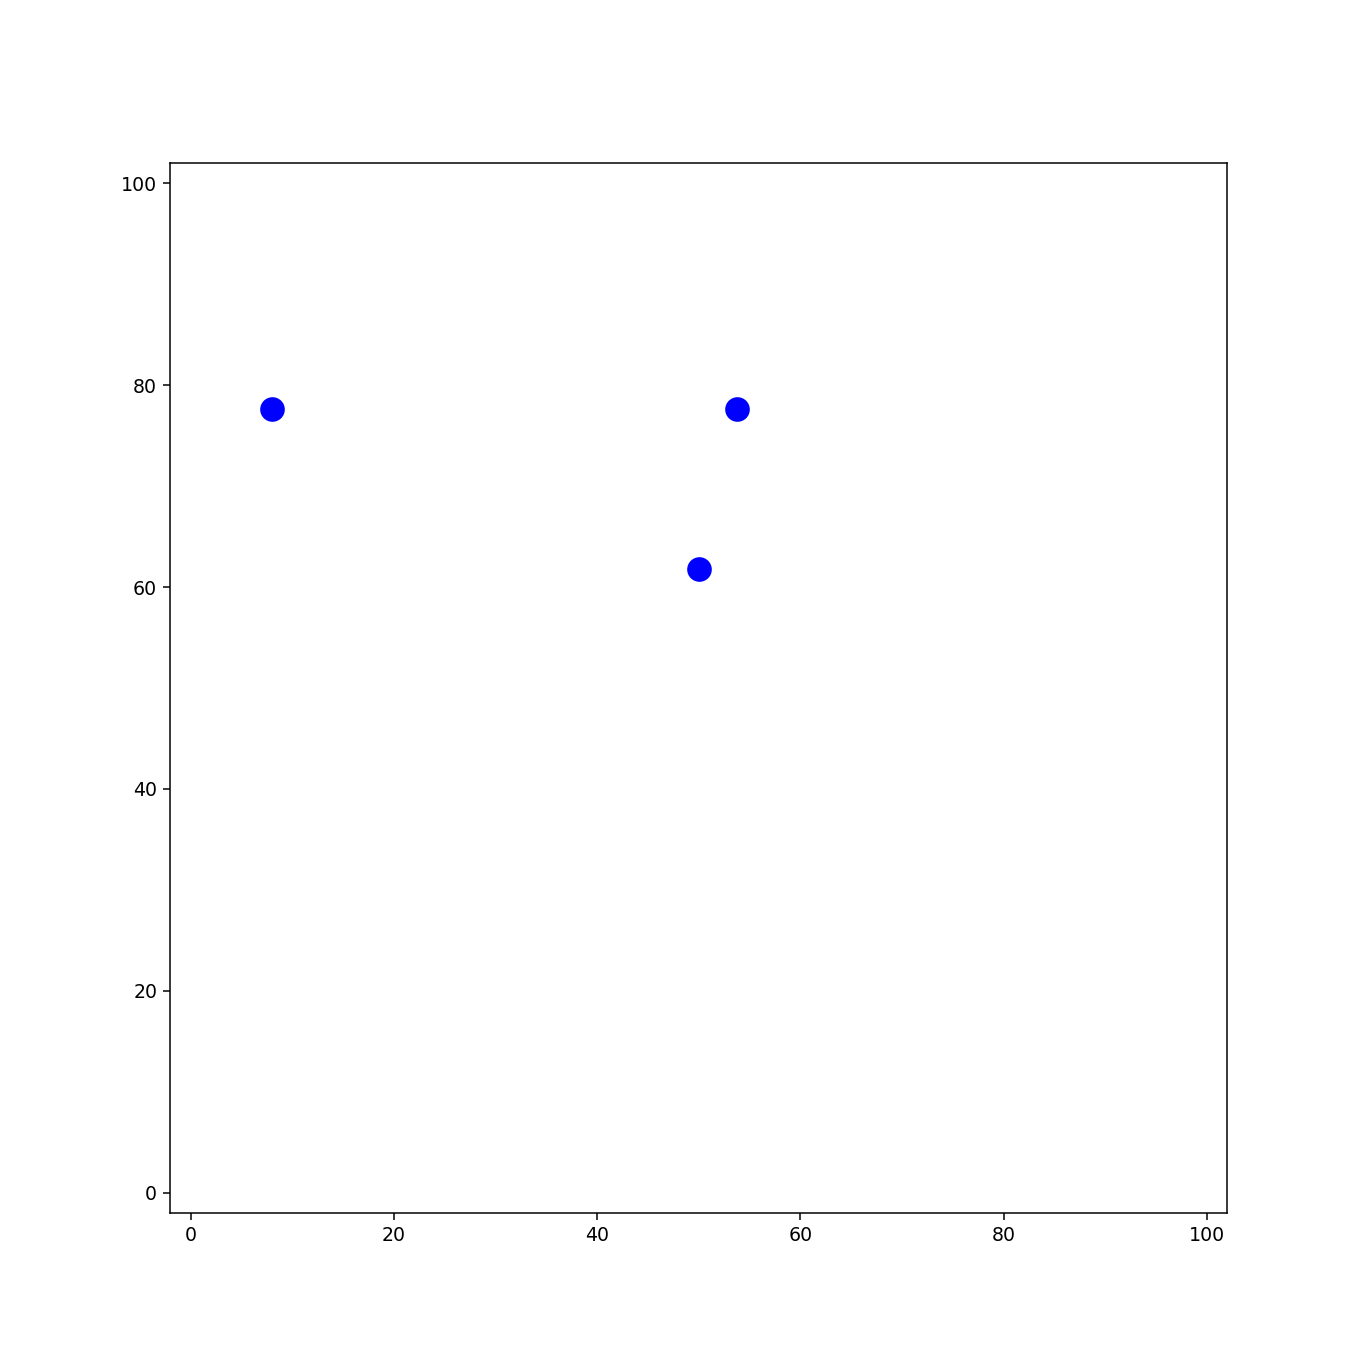

In [15]:
%run gas_2d.py

particles = [Particle(Vector(10,0),Vector(0,0.75),1,1),
             Particle(Vector(50,10),Vector(0,0.5),1,1),
             Particle(Vector(0,0), Vector(0.5,0.75),1,1)]
no_steps = 300

s=Simulation(particles, 100, 0.5)

for i in range(no_steps):
    s.step()
animate_trajectory(s)

## Generating initial conditions

The outcome of each simulation will depend strongly on the initial state of the system. Note that each Simulation object is created with initial conditions specified by a list of particle objects.

If we were to create a set of initial conditions with 100 particles, with radius and mass equal to 1, all equally spaced just above the bottom of the box, and with momentum with components along x and y equal to 0.5, we could write

    box_length=500
    N=100
    init_ordered=[]
    for p in range(1,N+1):
        pos=Vector(p*(N-1)/box_length,2)
        mom=Vector(0.5,0.5)
        init_ordered.append(Particle(pos,mom,1,1))

In [11]:
box_length=500
N=100
init_ordered=[]
for p in range(1,N+1):
    pos=Vector(p*box_length/(N+1),2)
    mom=Vector(0.5,0.5)
    init_ordered.append(Particle(pos,mom,1,1))

Create a simulation object with the init_ordered list, make a few simulation steps, and look at your results with animate_trajectory().

In [12]:
a=Simulation(init_ordered, N, 0.1)
no_steps1=500
for i in range(no_steps1):
    a.step()
animate_trajectory(a)

A useful set of initial conditions will be one where particles are randomly distributed in the box and random momenta in an interval \[-p<sub>max</sub>,p<sub>max</sub>\]. The [random()](http://docs.scipy.org/doc/numpy/reference/generated/numpy.random.random.html) function from numpy, which returns a random number between 0 and 1, is useful in this context.

    from numpy.random import random
    
    box_length=500
    N=100
    radius=1
    p_max=2
    init_random=[]
    for p in range(1,N+1):
        pos_x=random()*(box_length-2*radius)+radius   #avoid initial position too close to the walls
        pos_y=random()*(box_length-2*radius)+radius
        pos=Vector(pos_x,pos_y)
        mom_x=(random()-0.5)*2*p_max                  #allow for positive and negative momenta
        mom_y=(random()-0.5)*2*p_max
        mom=Vector(mom_x,mom_y)
        init_random.append(Particle(pos,mom,radius,1))

In [5]:
from numpy.random import random
import numpy as np
%run gas_2d.py

box_length=500
N=100
radius=1
p_max=2
init_random=[]
for p in range(1,N+1):
    pos_x=random()*(box_length-2*radius)+radius   #avoid initial position too close to the walls
    pos_y=random()*(box_length-2*radius)+radius
    pos=Vector(pos_x,pos_y)
    mom_x=(random()-0.5)*2*p_max                  #allow for positive and negative momenta
    mom_y=(random()-0.5)*2*p_max
    mom=Vector(mom_x,mom_y)
    init_random.append(Particle(pos,mom,radius,1))

def init_randomcon (N, radius, p_max, mass, box_length):
    init_random=[]
    for p in range(0,N):
        pos_x=random()*(box_length-2*radius)+radius   #avoid initial position too close to the walls
        pos_y=random()*(box_length-2*radius)+radius
        pos=Vector(pos_x,pos_y)
        angle=random()*2*np.pi
        mom_x=p_max*np.cos(angle)*(random()-0.5)*2                  #allow for positive and negative momenta
        mom_y=p_max*np.sin(angle)*(random()-0.5)*2
        mom=Vector(mom_x,mom_y)
        if radius == 0 and mass == 0:
            a=random()+1
            init_random.append(Particle(pos,mom,a*1,a*10))
        else:
            init_random.append(Particle(pos,mom,radius,mass))
    return init_random

def init_randomsqrlongsim ( N, box_length):
    init_random = []
    for p in range(0,N):
        pos_x = random() * box_length
        pos_y = random() * box_length
        pos = Vector(pos_x,pos_y)
        mom_x = random() - 0.5
        mom_y = random() - 0.5
        mom=Vector(mom_x,mom_y)
        init_random.append(Particle(pos, mom, 1, 1))
    return init_random

Run a few time steps of a simulation initialized with init_random, and see the result of your simulation.

In [172]:
%run gas_2d.py
b = Simulation(init_randomsqrlongsim ( 100, 100), 100, 0.25)
no_steps2=800
b.density

0.03141592653589788

In [173]:
%run gas_2d.py
for i in range(no_steps2):
    b.step()
#animate_trajectory(b,loop=True)
b.trajectory

[[<__main__.Particle at 0x213de526ef0>,

You may find yourself using the random set of initial conditions often, so you may consider to define a function to generate these.

# Collisions

We're making great progress but our simulation faces two problems:

   * Our particles pass through the boundaries of our box
   * Our particles pass through each other.
   
Let's focus on the boundaries problem to begin with. First execute the simple test we have below involving particles going through the boundary. We'll use this to test our code is behaving the way we want.

## Boundary Collision

<IPython.core.display.Javascript object>


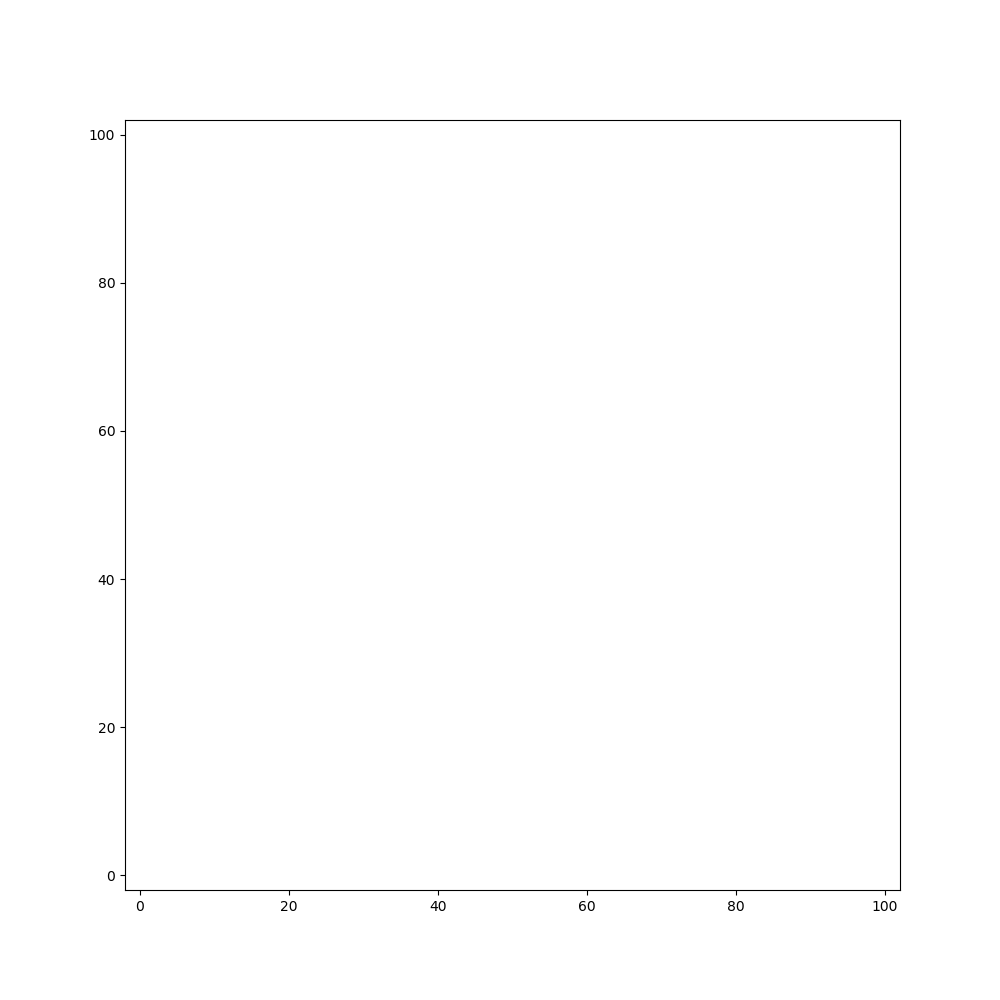

In [23]:
def test_box():
    '''Test case for particle collisions with boundary walls.
    Generate 4 particles colliding with each wall and animate the result.'''
    box_length = 100
    no_steps = 300
    
    p1 = Particle(position=Vector(10,50), momentum=Vector(-1,0),radius=1,mass=1)
    p2 = Particle(position=Vector(50,90), momentum=Vector(0,1) ,radius=1,mass=1)
    p3 = Particle(position=Vector(50,10), momentum=Vector(0,-1),radius=1,mass=1)
    p4 = Particle(position=Vector(90,50), momentum=Vector(1,0) ,radius=1,mass=1)

    box_particles = [p1,p2,p3,p4]

    s = Simulation(box_particles, box_length=100, dt=0.1)
    for i in range(300):
        s.step()
    return animate_trajectory(s,loop=True)

test_box()

Ok, let's update our simulation class so that instead of passing through our box they bounce off the edges. Our simulation class will now make use of the previously unused attribute *box_length* and it will need an additional method *apply_box_collisions*.

At the moment our particles' momenta remain unaltered no matter what happens. But we would like the momentum of a particle along the x-axis to reverse if it goes past the sides of our box, likewise we would like the momentum of a particle along the y-axis to reverse if it goes past the top or the bottom of our box.

Try implementing an apply_box_collisions method as outlined in the skeleton below. This method will receive as its argument a particle and then it will check whether that particle is past the boundaries of the box and if it is change it's momentum accordingly.

We'll then add in a call to apply_box_collisions in our step method that loops over all the particles.

    class Simulation():
        def __init__(self, particles, box_length, dt):        
            pass

        def apply_box_collisions(self, particle):
            pass

        def step(self):
            pass

        def record_state(self):
            pass

Test your simulation class by executing the cell below

<IPython.core.display.Javascript object>


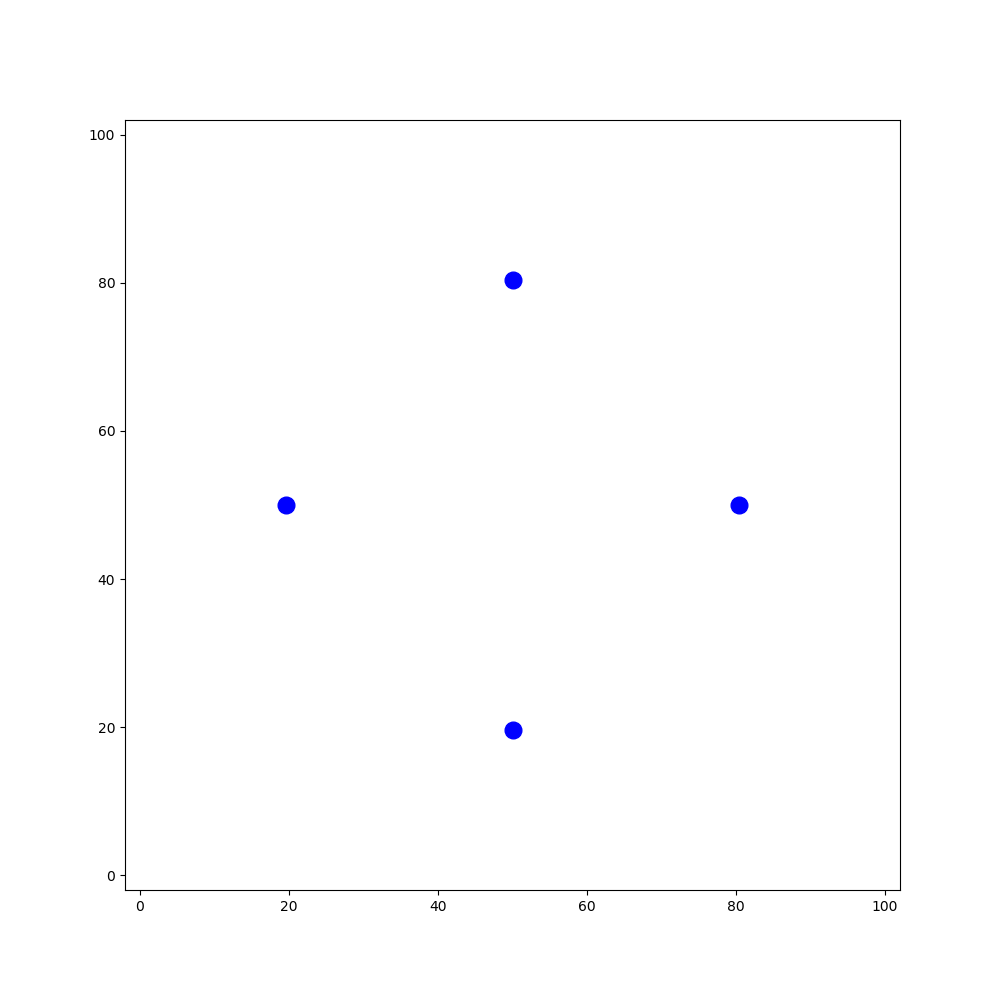

In [16]:
%run gas_2d.py

test_box()

## Particle Collisions

The final problem, and the most challenging is implementing inter-particle collisions.

The following 2 test cases show us the problem which we will addressing.

<IPython.core.display.Javascript object>


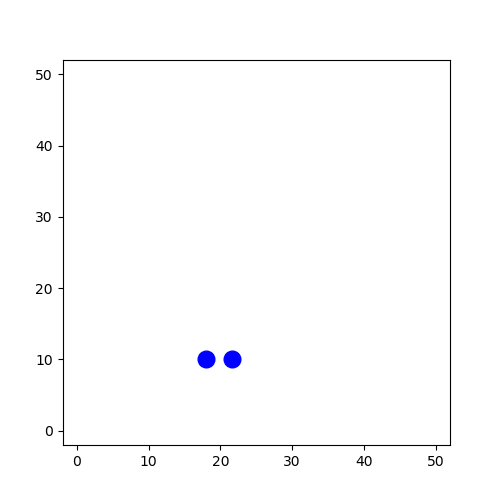

In [65]:
%run gas_2d.py

def test_1d_collision():
    '''Test case for particle collisions along the coordinate axis.
    Animate 2 particles, one moving and one at rest, colling along the x axis.'''
    box_length = 100
    no_steps = 300

    p1 = Particle(position = Vector(10,10), momentum=Vector(1.0,0.0),radius=1,mass=1)
    p2 = Particle(position = Vector(20,10), momentum=Vector(0,0) ,radius=1,mass=1)
    
    test_case = [p1,p2]
    s=Simulation(particles=test_case,box_length=50,dt=0.05)

    for i in range(500):
        s.step()
    return animate_trajectory(s,loop=True)

test_1d_collision()

<IPython.core.display.Javascript object>


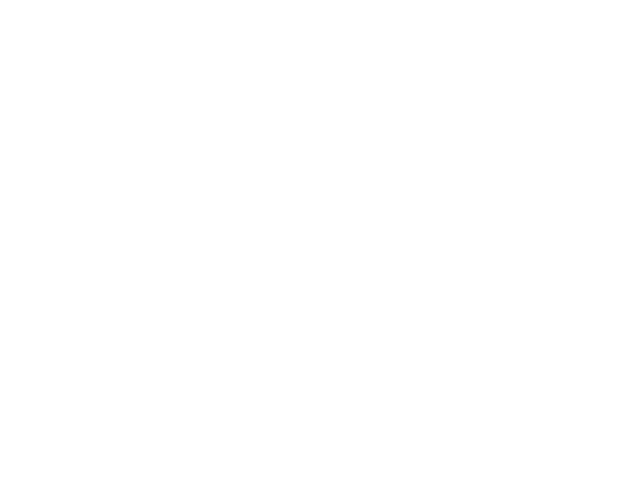

<IPython.core.display.Javascript object>


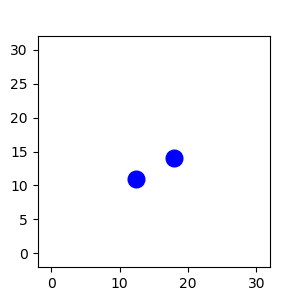

In [5]:
%run gas_2d.py
def test_2d_collision():
    '''Test case for general particle collisions in 2D.
    Animate 2 particles, one moving and one at rest, colliding in a diagonal direction.'''
    box_length = 100
    no_steps = 300

    p1 = Particle(position = Vector(10,10), momentum=Vector(1.2,0.5),radius=1,mass=1)
    p2 = Particle(position = Vector(20,15), momentum=Vector(-1,-0.5) ,radius=1,mass=1)
    
    test_case = [p1,p2]
    s=Simulation(particles=test_case,box_length=30,dt=0.05)

    for i in range(500):
        s.step()
    return animate_trajectory(s,loop=True)

test_2d_collision()

### Enhancing the Particle class first

One thing that will make our life easier is if we add another method to our particle class. In order to check whether two particles are going to collide we need to check whether they overlap. So we'll want to add an overlap method to our Particle class. This method will receive as it's second argument another particle (as always the first argument a method receives is always self). Our method will then return True if the distance between this other particle and itself is less than the sum of the two particle's radii otherwise it will return False. Extend the class in gas_2d.py in accordance with the class skeleton below:

    class Particle():
        def __init__(self, position, momentum, radius, mass):
            pass

        def velocity(self):
            pass
        
        def copy(self):
            pass
            
        def overlap(self, other_particle):
            pass

In the cell below create some particle objects and see if your overlap method behaves the way you expect it to.

In [74]:
%run gas_2d.py
particle1=Particle(Vector(0 , 0 ), Vector(1, 0,), 1, 1)
particle2=Particle(Vector(1.9 , 0 ), Vector(0, 0,), 1, 1)
particle1.overlap(particle2)

True

### 1D collisions

Now we can think about the collisions themselves. We're going to focus on perfectly elastic collisions and to start with we are going to make two additional simplifications: 

* We're going to pretend for now that we're dealing with [1 dimensional particles](https://en.wikipedia.org/wiki/Elastic_collision#One-dimensional_Newtonian) that only move along the x-axis.
* We're going to pretend that the masses of both particles are equal. 

Under these conditions the result of an elastic collision is that the momenta of the two particles simply swap over after the collision as illustrated from the following animation (by Simon Steinmann, on [wikimedia commons](https://commons.wikimedia.org/wiki/File:Elastischer_sto%C3%9F.gif)):

<img src=https://upload.wikimedia.org/wikipedia/commons/c/c6/Elastischer_sto%C3%9F.gif />

I.e.: 
$$\vec{p}_1: m\vec{v}_1 \rightarrow m\vec{v}_2$$ 
$$\vec{p}_2: m\vec{v}_2 \rightarrow m\vec{v}_1$$ 

Our particles are 2D as they have both x and y components for position and momentum, but if we make sure all the particles we're dealing with have the same y position and have 0 y momenta then they are effectively behaving like 1D particles.

Add a method *apply_particle_collision* to your simulation class that receives as its arguments two particles and if they overlap alters their momentum along the x-axis in line with an elastic collision.


    class Simulation():
        def __init__(self, particles, dt, box_length):
            pass

        def apply_particle_collision(self, particle1, particle2):
            pass

        def apply_box_collisions(self, particle):
            pass

        def step(self):
            pass

        def record_state(self):
            pass

In the cell below create a few particle objects and check that your method behaves the way you expect it to.

In [121]:
%run gas_2d.py
particletest = Simulation([particle1, particle2], 10, 0.1)
particletest.particles[0].momentum
particletest.particles[1].momentum
particletest.apply_particle_collision(particletest.particles[0],particletest.particles[1])
[particletest.particles[0].momentum, particletest.particles[1].momentum]

1.0
0.0
1.0
0.0
True


[0.0 0.0, 1.0 0.0]

Now we want our step method to apply particle collisions. But to do that we need to chack (loop over) all pairs of particles. Note that we want to avoid colliding particle i with particle j and then also separately colliding particle j with particle i (if we collide the same particles twice we will end up swapping their momenta twice, hence undoing the collision).

There are several different ways of looping over pairs, but perhaps the easiest is to use the function **combinations** from the itertools library. See example below:

In [133]:
from itertools import combinations

example_list = [1,2,3,4,5]
for p1,p2 in combinations(example_list,2):
    print(p1,p2)

1 2
1 3
1 4
1 5
2 3
2 4
2 5
3 4
3 5
4 5


Amend your step method so that it calls apply_particle_collision on all pairs of particles (you will need to import combinations at the top of your gas_2d.py file) and test your solution below:

In [1]:
%run gas_2d.py

test_1d_collision()

NameError: name 'test_1d_collision' is not defined

Before tackling 2D collisions, let us take a breath, for our enjoyment generate some particles and create a simulation object *sim_1d* with 200 time steps.

In [168]:
particles = init_randomcon(10, 1, 1, 1, 10)

sim_1d = Simulation(particles, 10, 0.1)
for step in range(200):
    sim_1d.step()


Animate your simulation in the cell below (your code can now simulate a 1D gas!):

In [185]:
animate_trajectory(sim_1d, loop=True)

## 2D collisions

Ok back to collisions! Currently we represent our momentum in terms of two directions x and y. What we're going to do for our 2D case is to work out a different representation of the momentum in terms of two different directions. We will choose these directions in such a way that the collision will leave the second component completely unchanged, this essentially turns the 2D problem into the 1D problem we already know how to solve.

What are these two directions? The first is the inter-particle direction at the moment the collision take place. We'll call this the *collision axis*. The other will be at 90 degrees to the collision axis and we'll call the *orthogonal axis*.

What we expect in our simplified case then is that following collision the components of the momentum of the particles along the collision axis will swap over whilst components along the  orthogonal axes will remain unchanged.

To make this a bit clearer let's look at the following animation (by Simon Steinmann, from [wikimedia commons](https://commons.wikimedia.org/wiki/File:Elastischer_sto%C3%9F_2D.gif)):

<img src=https://upload.wikimedia.org/wikipedia/commons/2/2c/Elastischer_sto%C3%9F_2D.gif />

What you are seeing is one particle in motion and another at rest. At the point where the two particles collide, the animation displays the collision and orthogonal axes as perpendicular black lines. 

The momentum of the moving particle (displayed as a red arrow) is expressed as components along these two axes (these are displayed as two blue arrows).

The stationary particle initially has no momentum, which means that both its collision and orthogonal component are initially zero.

During the collision the two particles swap momenta along the collision axis.

In the case illustrated, for the initially moving particle, the collision component of the momentum becomes zero, leaving only its initial orthogonal component contributing to the final momentum. 

For the initially stationary particle, the initial orthogonal component is zero so the final momentum is equal to the collision component of initially moving particle prior to collision.

You may need to read this section a few times and stare at the animation for it to make sense. If after doing so it is still unclear please ask a demonstrator!

### Projecting the momentum along the collision and orthogonal axes

Luckily our vector class includes all the necessary methods to calculate the collision and orthogonal axes and express the momentum in terms of components along them.

To workout the component of a vector in the direction of a particular axis, we need only calculate the dot product of the vector with that particular axis (a scalar), multiplied by the axis vector itself. Shown below is a figure (by user Acdx, from [wikimedia commons](https://upload.wikimedia.org/wikipedia/commons/f/fd/3D_Vector.svg)) for a 3 dimensional vector **a**, axis vectors **i**,**j**, and **k** and vector components **a<sub>x</sub>**, **a<sub>y</sub>** and **a<sub>z</sub>**.

<img src="https://upload.wikimedia.org/wikipedia/commons/f/fd/3D_Vector.svg" />

E.g. to calculate the component of a particular vector *vec* along the x-axis we would compute:
    
    vec = Vector(3,4)

    xaxis = Vector(1,0)
    vec_proj_x = xaxis * vec.dot(xaxis)
    vec_proj_x

In [6]:
vec = Vector(3,4)

xaxis = Vector(1,0)
vec_proj_x = xaxis * vec.dot(xaxis)
vec_proj_x

3 0

Like wise to calculate the component of a vector *vec* along the y-axis we would compute:
    
    yaxis = Vector(0,1)
    vec_proj_y = yaxis * vec.dot(yaxis)
    vec_proj_y

In [7]:
yaxis = Vector(0,1)
vec_proj_y = yaxis * vec.dot(yaxis)
vec_proj_y

0 4

Of course for x and y we have an easier option for working out the magnitude of along the x and y axes: we can simply use the .x and .y attributes. However this only works for x and y, whereas our general dot product approach works for any axes with might like to consider.

    new_axis = Vector(0.6,0.8)
    vec_proj_new_axis = new_axis * vec.dot(new_axis)
    vec_proj_new_axis

In [102]:
new_axis = Vector(0.5, (1-0.5**2)**0.5)
old_vector = Vector( new_axis.norm() *(-1)* np.cos(new_axis.angle(Vector(0,1))), new_axis.norm()*(-1) * np.sin(new_axis.angle(Vector(0,1))))
old_axis=old_vector/old_vector.norm()
vec_proj_new_axis = new_axis* vec.dot(new_axis) #vec = Vector(3,4)
vec_proj_old_axis = (old_axis) * vec_proj_new_axis.dot(old_axis)
vec_proj_old_axis

3.723076211353315 2.1495190528383286

An important point to bear in mind is that an axis vector **must always have a length of 1**. If we have a vector whose direction we would like to use as an axis, we must first normalise it such that it's length is 1 leaving its direction unchanged. To do this we divide the vector by its own length:

    normalised_vec = vec/vec.norm()
    print(vec)
    print(normalised_vec)

In [9]:
normalised_vec = vec/vec.norm()
print(vec)
print(normalised_vec)

3 4
0.6 0.8


Having chosen one axis, we can work out the component in the direction perpendicular to it by subtracting the component along our chosen axis from our initial vector.

    new_xaxis = Vector(0.6,0.8)
    vec_proj_newx = new_xaxis * vec.dot(new_xaxis)
    vec_proj_newy = vec - vec_proj_newx

In [53]:
new_xaxis = Vector(0.6,0.8)
vec_proj_newx = new_xaxis * vec.dot(new_xaxis)
vec_proj_newy = vec - vec_proj_newx
vec_proj_newx

3.0 4.0

We now have assembled all the pieces we need to update our apply_particle_collision method for 2D collisions.

For colliding particles you will want to: 

* compute the collision axis
* compute the projection of the momentum onto the collision and orthogonal axes
* update the collision projected momentum
* compute the new total momentum

Have a go updating your simulation class then execute the cell below to test your code.

0
0.0
0.0
0.0
True
0.0
0.0
0.0
0.0
True
0.0
0.0
0.0
0.0
True
0.0
0.0
0.0
0.0
True
0.0
0.0
0.0
0.0
True
0.0
0.0
0.0
0.0
True
0.0
0.0
0.0
0.0
True
0.0
0.0
0.0
0.0
True
0.0
0.0
0.0
0.0
True
0.0
0.0
0.0
0.0
True
0.0
0.0
0.0
0.0
True
0.0
0.0
-2.220446049250313e-16
-1.1102230246251565e-16
False
-2.220446049250313e-16
-1.1102230246251565e-16
-4.440892098500626e-16
-2.220446049250313e-16
False
-4.440892098500626e-16
-2.220446049250313e-16
-6.661338147750939e-16
-3.3306690738754696e-16
False
-6.661338147750939e-16
-3.3306690738754696e-16
-4.440892098500626e-16
-2.220446049250313e-16
False
-4.440892098500626e-16
-2.220446049250313e-16
-4.440892098500626e-16
-2.220446049250313e-16
True
-4.440892098500626e-16
-2.220446049250313e-16
-4.440892098500626e-16
-2.220446049250313e-16
True
-4.440892098500626e-16
-2.220446049250313e-16
-6.661338147750939e-16
-3.3306690738754696e-16
False
-6.661338147750939e-16
-3.3306690738754696e-16
-6.661338147750939e-16
-3.3306690738754696e-16
True
-6.661338147750939e-1

<IPython.core.display.Javascript object>


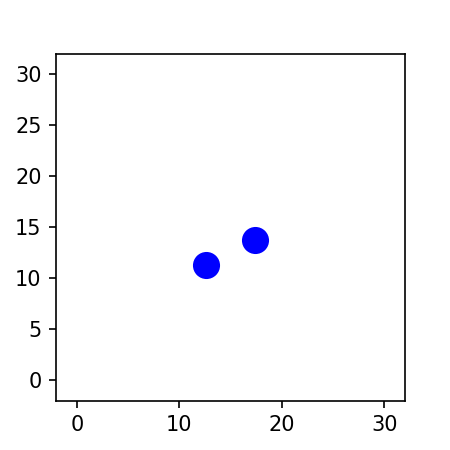

In [122]:
%run gas_2d.py

test_2d_collision()

Fantastic, we can simulate 2D collisions!

## Fixing a bug

We've tested our code in the most obvious way but there is a final test case we need to take a look at.

Execute the cell below and watch the animation of the simulation. What do you think is going on?

<IPython.core.display.Javascript object>


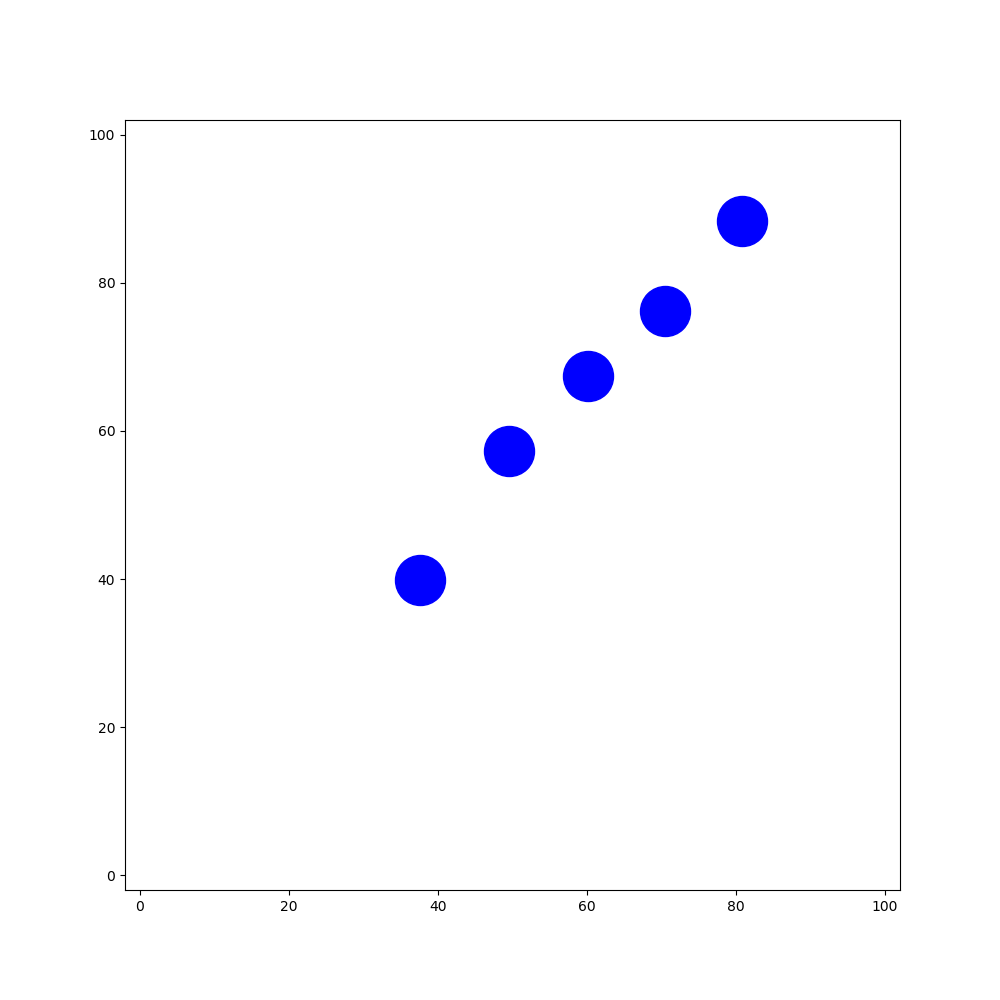

In [70]:
%run gas_2d.py
def test_collision_bug():
    '''Test case for sticking particles bug. Animate the collision of 5 particles
    that could result in particles trapping each other.'''
    box_length = 100
    no_steps = 300

    p1 = Particle(position = Vector(45,50), momentum=Vector(1,1),radius=3,mass=1)
    p2 = Particle(position = Vector(55,60), momentum=Vector(0,0) ,radius=3,mass=1)
    p3 = Particle(position = Vector(35,39.75), momentum=Vector(2,2),radius=3,mass=1)
    p4 = Particle(position = Vector(65,70.25), momentum=Vector(-1,-1),radius=3,mass=1)
    p5 = Particle(position = Vector(54,30), momentum=Vector(0.5,2.5),radius=3,mass=1)
    
    test_case = [p1,p2,p3,p4,p5]
    
    s=Simulation(particles=test_case,box_length=100,dt=0.25)

    for i in range(1000):
        s.step()
       
    return animate_trajectory(s,loop=True, interval=85)  

test_collision_bug()


Our particles are binding even though we haven't implemented atractive interactions?! What the juice?

Think about what would happen if you initialised your particles so that they started off moving slowly but already overlapping with one another? What would happen to their momenta on every step?

To solve this problem we need to check whether or not two particles are actually moving towards one another before deciding to collide them. As you know how to determine the the momentum components along the collision axis, you should be able to add a check to make sure they are moving towards each other prior to switching their momenta.

The same problem can manifest along the boundaries (where particles can also get stuck) so you'll want to apply the same solution to your box_collisions method. Modify *apply_box_collisions* and *apply_particle_collisions* to solve the bug and test your solution below:

<IPython.core.display.Javascript object>


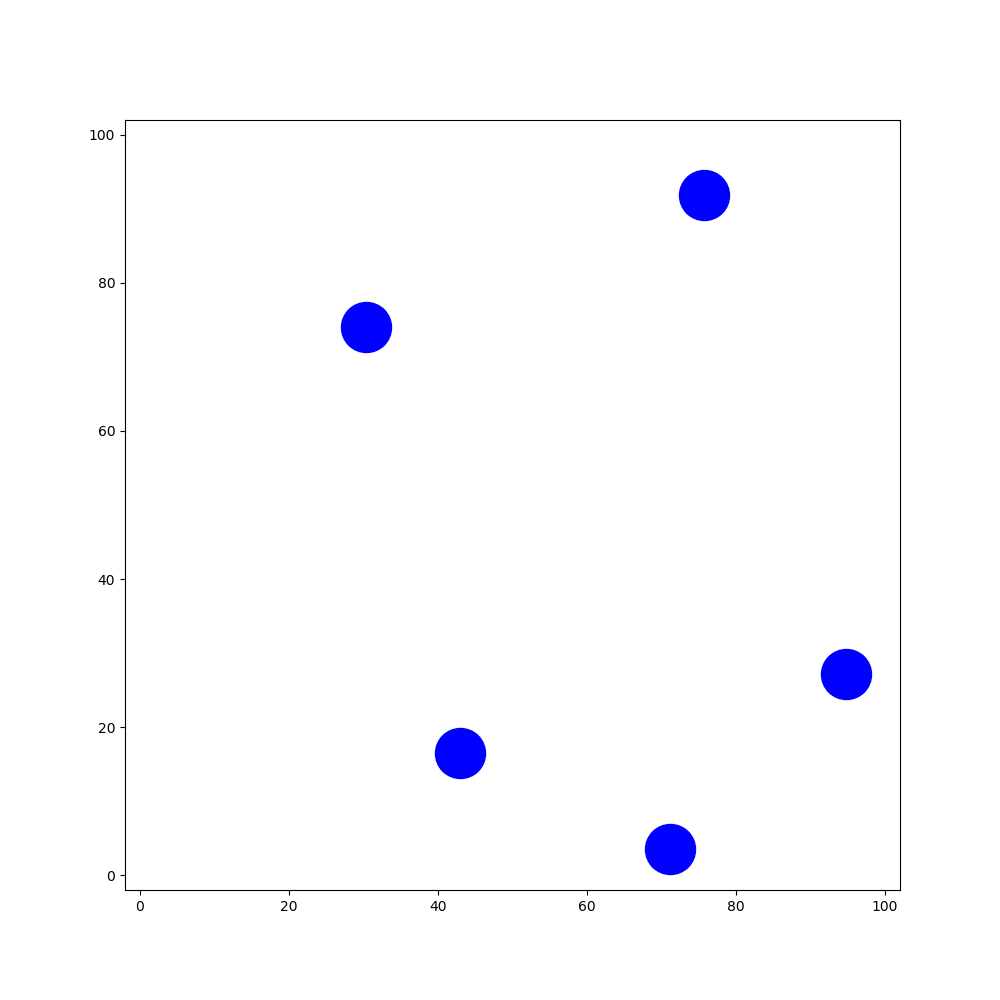

In [94]:
%run gas_2d.py

test_collision_bug()


**Congratulations you've written a particle simulation!**

Try out simulations with different initial conditions to see what happens. (Warning if you create a simulation with too many particles it will take a long time to run!)

In [85]:
c = Simulation (init_randomcon(100, 1, 1, 1, 100), 100, 0.10)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<IPython.core.display.Javascript object>


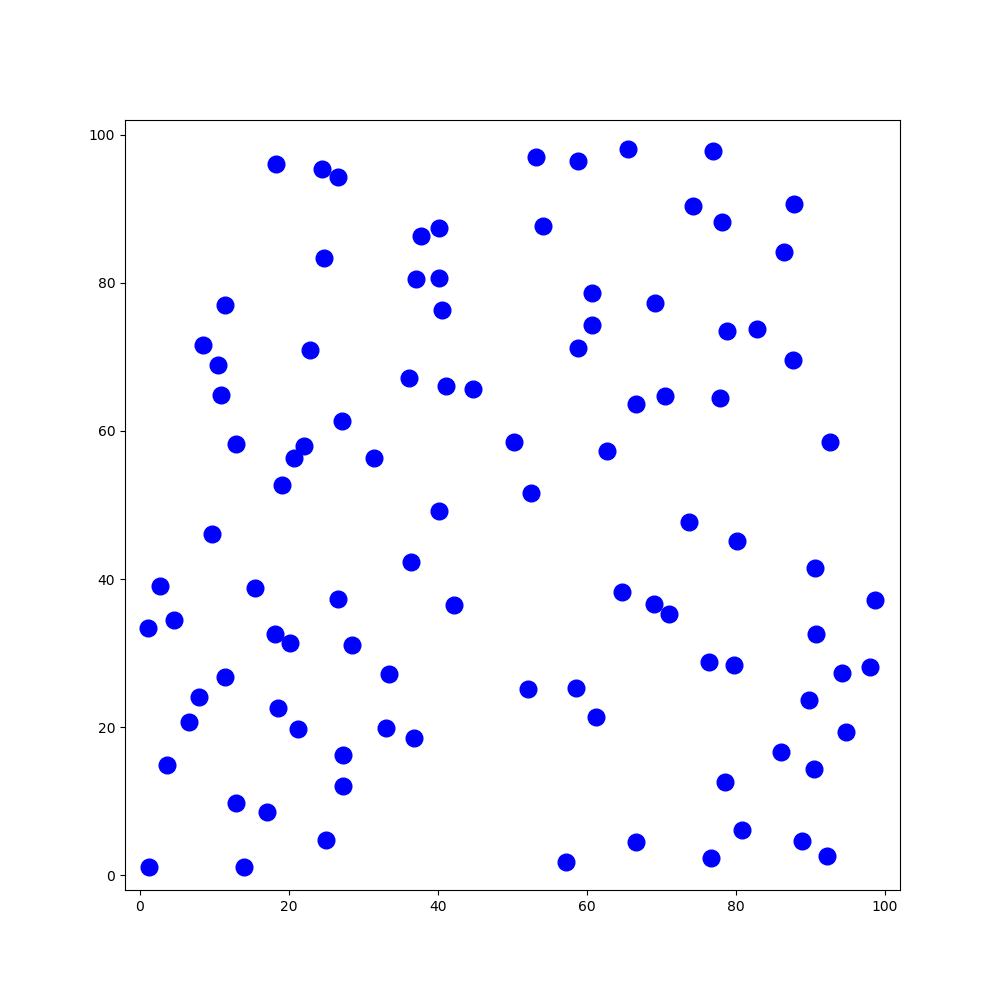

In [111]:
%run gas_2d.py
no_steps2=1000
for i in range(no_steps2):
    c.step()
    #percentage_complete = (i / no_steps2) * 100
    print(i)
    #if percentage_complete.is_integer():
      #  print (percentage_complete, '%')
animate_trajectory(c,loop=True)

## Allowing for particles with different masses

This part of the project offers less guidance, so you're on your own from here!

We have assumed so far that all particles have the same mass and hence that:

$$\vec{p'}_1 = \vec{p}_2 $$
$$\vec{p'}_2 = \vec{p}_1 $$

where the subscripts indicate the particle. $\vec{p'}$ is the momentum after the collision and $\vec{p}$ is the momentum before the collision.

But there is no reason to make this assumption. The correct formula for a 1D collision in the case of different particle masses is:
    
$$\vec{p'}_1 = \frac{(m_1-m_2)\vec{p}_1+2m_1\vec{p}_2}{m_1+m_2}$$
$$\vec{p'}_2 = \frac{(m_2-m_1)\vec{p}_2+2m_2\vec{p}_1}{m_1+m_2}$$

Update your Simulation so that it can handle cases where particles have different masses and test it out on a suitable test case of your own devising.

In [4]:
d = Simulation (init_randomcon(100, 5, 1, 1, 100), 100, 1)
no_steps3=2000
for i in range(no_steps3):
    d.step()
    percentage_complete = (i / no_steps3) * 100
    #print(i)
    if percentage_complete.is_integer():
        print (percentage_complete, '%')
animate_trajectory(d,loop=True)

NameError: name 'init_randomcon' is not defined

## Generating a longer simulation

Our goal is to generate a larger simulation to try to derive some statistical information of the system. You might have noticed from your trials however that these simulations are somewhat slow. Yes, Python does not generate the fastest programs.

We have tried some black magic by coding special fast Vector and Particle classes. If they load, your simulations may accelerate significantly.

In [1]:
import pyximport
pyximport.install()

from fast_classes import Vector,Particle

ImportError: Building module fast_classes failed: ['distutils.errors.DistutilsPlatformError: Unable to find vcvarsall.bat\n']

If your system does not have the necessary components configured and you get an error when importing the classes above, then you need to fall back to the Python classes you defined and wait a little longer for your simulations to run.

Now create a simulation of 200 particles in 100 length box, with 0.5 for the x/y components of the momenta then simulate 10,000 steps with dt=0.25 (it may take a while).

In [9]:
%run gas_2d.py
import pickle
f = Simulation (init_randomsqrlongsim( 200, 100) , 100, 0.25)
#with open('longsim.dat','rb') as data:
#    longsim = pickle.load(data)
for i in range(0, 2500):
    f.step()
    percentage_complete = (i / 2500) * 100
    #print(i)
    if percentage_complete.is_integer():
        print (percentage_complete, '%', end="\r")


Animate the trajectory on the cell below

<IPython.core.display.Javascript object>


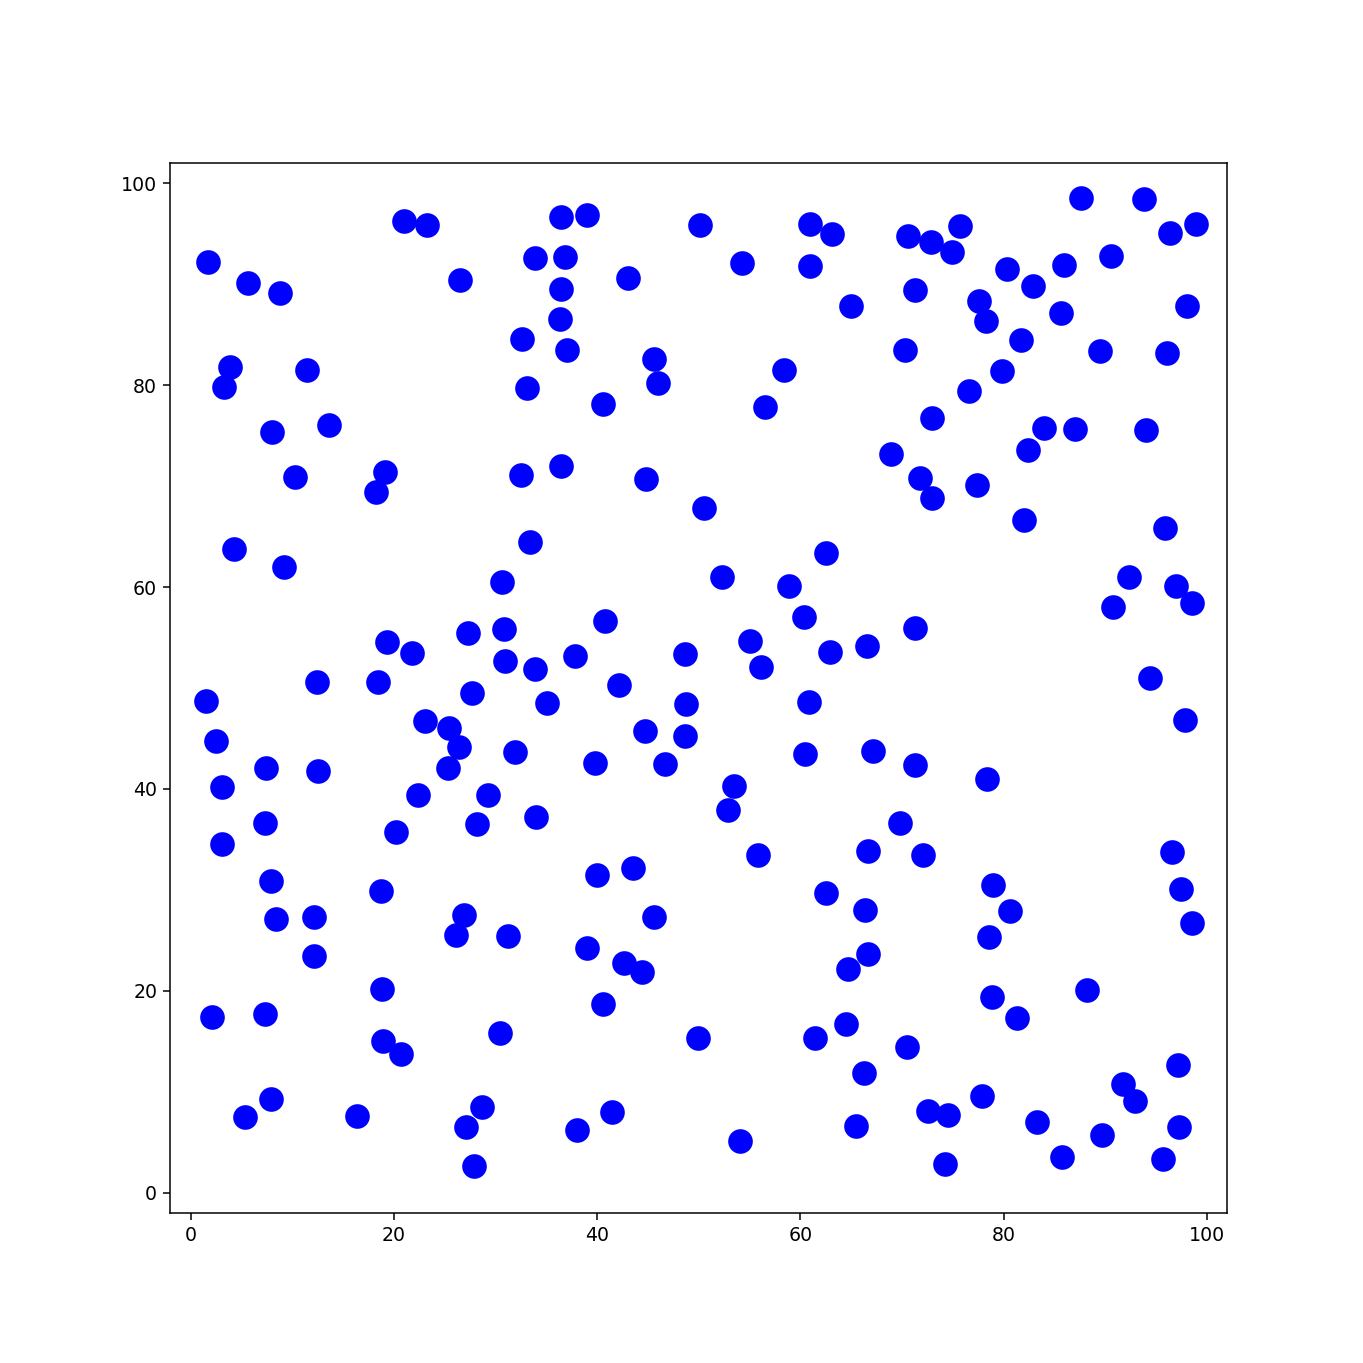

In [8]:
animate_trajectory(longsim,loop=True)

In [5]:
#with open('longsim2.dat','wb') as data:
 #   pickle.dump(longsim, data)

In [7]:
import pickle
%run gas_2d.py
with open('longsim2.dat','rb') as data:
    longsim = pickle.load(data)


0.25

In [10]:
len(longsim.trajectory)

30001

## Saving your simulation

Although not affecting the physical behaviour of the simulated system, it is extremely useful to be able to save the results of our simulations. We will often want to save a simulation so we switch off the notebook but still be able to come back to either analyse or even continue the simulation at a later date.

Python allows any object to be saved to disk using the Pickle library. Lets try it out. For this purpose we will create some particles and generate a simulation object *shortsim* with 200 steps

<IPython.core.display.Javascript object>


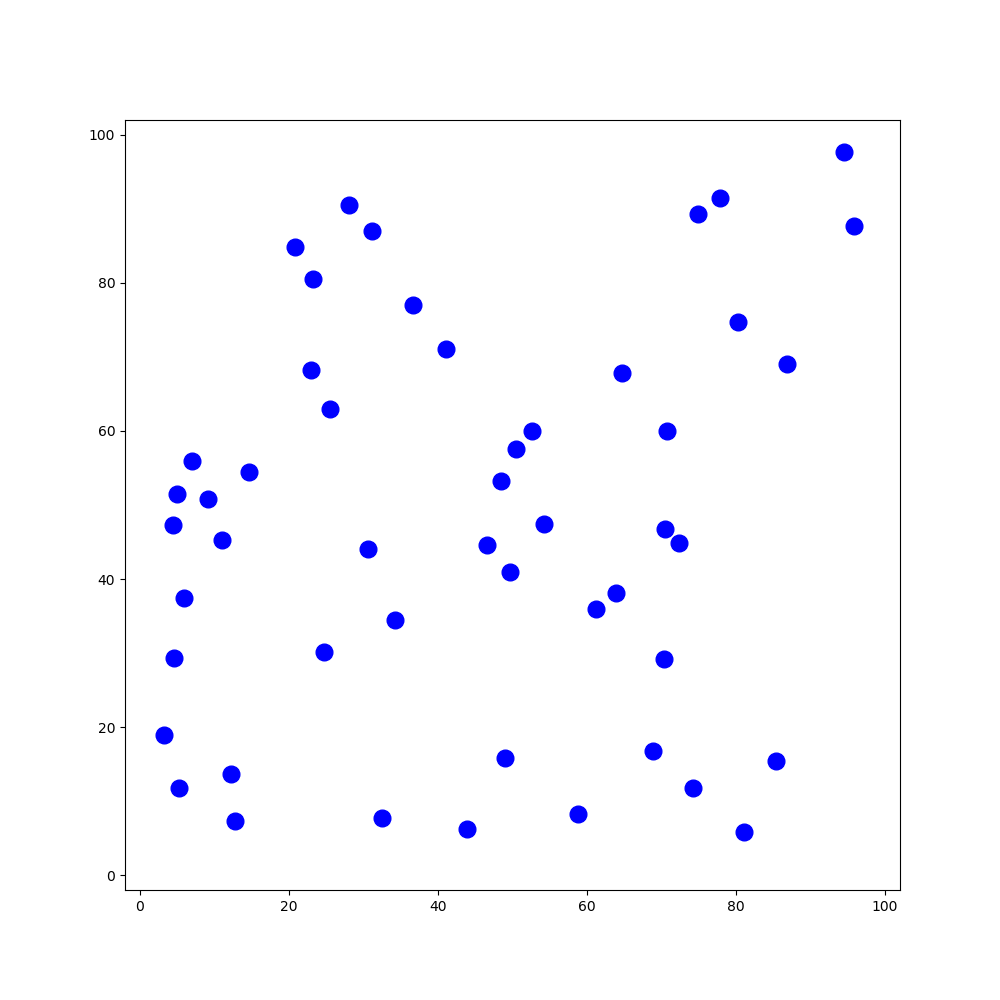

In [138]:
particles = init_randomsqrlongsim( 50, 100)

shortsim = Simulation (particles, 100, 0.25)

for step in range(200):
    shortsim.step()
    percentage_complete = (step / 200) * 100
    if percentage_complete.is_integer():
        print (percentage_complete, '%', end="\r")

animate_trajectory(shortsim,loop=True)

Now we'll use pickle to save it (note we will need to import the pickle module). This involves:

* Opening a binary file for writing by using the open function with the 'wb' flag.
* Calling pickle's dump function to dump our simulation object into the file (requires pickle has been imported).
* (When using the with construction, the file is closed after writing)

Below we pick the file name test_simulation.dat but in general you can choose whichever filename you wish.

In [10]:
import pickle

#with open('test_simulation1.dat','wb') as data_f:
 #   pickle.dump(shortsim,data_f)

with open('longsim.dat','wb') as data:
    pickle.dump(f, data)

To extract our simulation from the file we have created requires:
    
* Opening a binary file for reading by using the open function with the 'rb' flag.
* Calling pickle's load function to extract our simulation object from the file (requires pickle has been imported).

So to extract the simulation we just saved we would execute:

In [7]:
with open('test_simulation.dat','rb') as data_f:
    loaded_sim = pickle.load(data_f)

FileNotFoundError: [Errno 2] No such file or directory: 'test_simulation.dat'

We can now add further steps to the simulation/and or run analysis on it.

In [1]:
for step in range(200):
    loaded_sim.step()
    
animate_trajectory(loaded_sim)

NameError: name 'loaded_sim' is not defined

An important thing to be aware of is that if you update or change your classes in any way (adding attributes or modifying methods), your pickled file will no longer be loadable because your class definition does not match the stored object.

# Looking at Physical Quantities - Writing your report

Write a short report in the form of a Jupyter notebook where you analyse the results of your simulations. Below are some items that should guide your analysis.

In your analysis you will probably be writing some functions. You could write these as methods on the simulation class, but it is probably better to write these in the report notebook as functions which receive a simulation object as an argument.

Your report might be short, but it should include figures (possibly some code) and comments on the results you obtain. 

### A note on units and density of the system

We have been a bit sloppy with the use of units while building our simulation, in fact we have not addressed this issue at all! When we write dt=0.25, do we mean that the time step is 0.25 femtoseconds, or 0.25 years? Same question arises about for box size or particle mass. This is not an issue when it comes to the "correctness" of the result, or the qualitative behaviour of the simulated system, but it does become an issue when we want to compare quantities with experiments.

We are free to choose our unit system, but when we want to simulate a specific physical system (for example, a container of Xe atoms at T=300K), we must have a  particle_radius/box_length ratio that is consistent with the system we want to simulate, or an initial momentum that is consistent with the target temperature.

Since we did not pay attention to our choice of parameters, we are not quite sure what physical system we have been simulating. In the analysis below, we will just focus on the qualitative behaviour of the system in an arbitrary system of units.

One quantity that is very useful to characterise the system and remains meaningful in any system of units is the density, taken here as the fraction of the area occupied by the particles compared to the total area of the box.

* Add a density attribute to your Simulation class and calculate its value in the \_\_init\_\_ method.

Systems with low densities can be seen as gases while high densities will behave more like liquids. For higher densities still, when the particles start being packed in space, the system will have the properties of a solid.

### Energy as a function of time
Using your simulation trajectory, produce a plot of total (kinetic) energy versus time for the simulation.

### Distribution of speeds
Every recorded state defines a distribution of particle velocities and particle speeds. 

Plot the evolution of the standard deviation of the particle speeds as a function of time, and see if you have reached equilibrium or if you need to run your simulation for longer.

Below is a skeleton for a function *plot_speeds* that accepts as its argument an integer defining the particular time step we are interested in and will plot the histogram of speeds present at that time step. (You may need to run %matplotlib to get the interactive plot to work). Fill out this function and use it to find out how many time steps your simulation takes untill the distribution no longer changes significantly.

    from ipywidgets import interact
    from matplotlib.pyplot import *

    @interact(t=(0,1000,1))
    def plot_speeds(t):
        pass

To get a better distribution we need better statistics, so a simulation with a higher number of particles will work better. A simulation with a high rate of collisions (higher density) will also equilibrate quicker.

For a configuration after the equilibrium is reached, produce two histograms: one of the *x* component of the velocity for all particles; and another with of the speed of the particles. Overlay and compare these histograms with the theoretical distributions. 

The probability distribution for a component of the velocity, i.e. the probability $\rho_x$ of finding a particle with *x* component of velocity $v_x$, should be gaussian

$$\rho_x(v_x)=\sqrt{\frac{m}{2 \pi k_B T}} \exp\left(-\frac{mv^2}{2k_BT}\right)$$

Where $m$ is the mass, $k_B$ is Boltzmann's constant and $T$ is the temperature. The Maxwell-Boltzmann distribution of speeds in 2D is:
    
$$\rho(v)=\frac{m v}{k_B T} \exp\left(-\frac{mv^2}{2k_BT}\right)$$ 

The relationship between the temperature and the average energy for a 2D ideal gas is:

$$\langle E \rangle= k_BT$$

Workout the average energy per particle for your simulation and use this value along with the mass you gave your particles to plot your distributions.

### Distribution of positions

Produce a density profile of the system along the *x* direction. To do this choose a fraction of the trajectory where the system is in equilibrium and histogram the *x* position of the particles. Use a bin size smaller than the radius of your particles, and to improve statistics you should accumulate many timesteps in a single histogram.

Try also systems with a relative high density (for example 0.18 or more). Is the result you obtain what you expected?

## Optional (hard!)

Except for the first case below, the tasks suggested here are harder and can take a significant time to complete. **You are not expected to complete any of them, and it is possible to obtain full marks without completing this part of the project**. These tasks are presented as suggestions of ways in which the simulations could be improved. Contact the demonstrators if you want to discuss implementing any of these features.

### Expansion of the gas

Build a simulation where all particles are randomly distributed but only on the left half of the box. The right half of the box is empty. Momenta of the particles can be randomly distributed.

Run the simulation and observe the result.

As a function of time, count the number of particles on each side of the box, and plot them on the same figure. How long does it take to reach equilibrium? Does it change, if you change the maximum initial momentum?

### Mixing

You can use the program you developed to study diffusion and mixing. You can start a simulation with different particles on the left and right halves of the box (what distinguishes the particles could be a physical attribute such as mass, or a fictitious one such as colour). Your simulation could look [something like this](http://www.imperial.ac.uk/chemistry-teaching/chemicalequilibria/moleculesmixing2.html). Plot the number of particles of each type on each side of the box as a function of time.

### Pressure on the container walls

Can you modify the boundary code so that you can record the pressure being exerted on the box during each time step and hence produce a plot of pressure vs. time? Does your simulation agree with the ideal gas equations?

You can plot the pressure for changing system density. You may be able to observe a phase transition.

### Heat transfer across the boundary

At the moment the system we are simulating is isolated: there are no exchanges of mass or energy with the surroundings. We could however allow for the transfer of heat at the boundary, in which case collisions with the walls would no longer be elastic. What would happen if you had walls that were warmer/cooler than the gas?

Implement the heat change with the box walls and look how the total energy of the gas changes with time.

### Simulating properties of the bulk

#### Periodic boundary conditions
The systems we have been simulating have a very large surface area to volume ratio (or in this case, large perimeter to area ratio). Contrast the particle radius and the box length you have been using, with the radius of a molecule compared with a 1 litre container. Our simulations thus greatly overestimate boundary effects as we saw when plotting the density profile of the system, and are therefore unsuitable to study bulk properties.

A very common technique to study bulk properties is to use [periodic boundary conditions](https://en.wikipedia.org/wiki/Periodic_boundary_conditions). In this case the walls are completely suppressed and a particle crossing the boundary on one side of the box is placed on the opposing side of the box, keeping the same momentum. Thus simulating an "infinite" box. Special care must be taken measuring distances between particles and checking for collisions across the box boundary.

Implement a simulation class with periodic boundary conditions.

#### Radial distribution function
One quantity often used to describe the structure of fluids is the [radial distribution function g(r)](https://en.wikipedia.org/wiki/Radial_distribution_function). This quantity measures the probability of 2 particles being at a distance r from each other. Make a plot of the g(r) for one of your simulations.

### Speeding up the simulations

Our simulation is quite slow (you can see where the code is spending its time by including %%prun at the top of a cell and then executing your simulation code). Most of the computational expense is in the particle collisions because there are N(N-1)/2 pairs of particles. One way to reduce this expense is to divide the box up into quadrants, keep track of which quadrant the particles are in and then when executing the particle_collision code only look for collisions between pairs of particles in the same quadrant. Care needs to be taken when thinking about particles on the edges of the quadrants. Can you speed up the code in this way?

In [ ]:
%%prun

pass

# Bibliography

* W. Krauth, [Statistical Mechanics: Algorithms and Computations](http://imp-primo.hosted.exlibrisgroup.com/ICL_VU1:LRSCOP_44IMP:44IMP_ALMA_DS2146738160001591), Oxford University Press, 2006